Загрузка данных

In [405]:
from alpaca.data.timeframe import TimeFrame
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
import datetime

API_KEY = "PK1W6UGQYV6DJYD9HEP7"
SECRET_KEY = "ndH61mpUAGkK7jNKM8fgl1EvjUQKf0yDofyYP0pe"

client = CryptoHistoricalDataClient()
request_params = CryptoBarsRequest(
  symbol_or_symbols=["BTC/USD", 'ETH/USD', 'USDT/USD', 'XRP/USD', 'SOL/USD', 'USDC/USD', 'DOGE/USD', 'BCH/USD', 'LINK/USD', 'AVAX/USD'],
  timeframe=TimeFrame.Day,
  start=datetime.datetime(2020, 7, 1),
  end=datetime.datetime(2025, 7, 1)
)

btc_bars = client.get_crypto_bars(request_params)

df = btc_bars.df

df = df.sort_index(level=["symbol", "timestamp"])

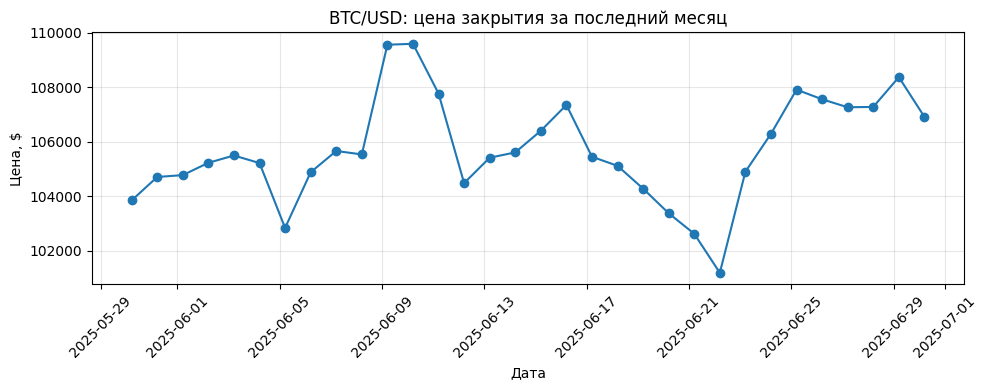

In [406]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Данные только для биткоина
btc = df.xs('BTC/USD', level='symbol').sort_index()

# 2. Последний день и стартовый день (‑1 календарный месяц)
last_date  = btc.index.max()                         # например, 2025‑07‑01 00:00:00+00:00
start_date = (last_date - pd.DateOffset(months=1)).normalize()

# 3. Срез за нужный интервал
btc_month = btc.loc[start_date:last_date]

# 4. График
plt.figure(figsize=(10, 4))
plt.plot(btc_month.index, btc_month['close'], marker='o')
plt.title('BTC/USD: цена закрытия за последний месяц')
plt.xlabel('Дата')
plt.ylabel('Цена, $')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# (необязательно) сохранить картинку
# plt.savefig('btc_last_month.png', dpi=300)


Добавление меток о сезоне и дне недели

In [407]:
import pandas as pd

ts = df.index.get_level_values('timestamp')
ts = pd.to_datetime(ts)

dow_dummies = pd.get_dummies(ts.day_name(), prefix='is', dtype=bool).reindex(
    columns=['is_Monday', 'is_Tuesday', 'is_Wednesday', 'is_Thursday',
             'is_Friday', 'is_Saturday', 'is_Sunday'], fill_value=False)

def season(month):
    if month in (12, 1, 2):
        return 'winter'
    elif month in (3, 4, 5):
        return 'spring'
    elif month in (6, 7, 8):
        return 'summer'
    else:
        return 'autumn'

season_dummies = pd.get_dummies([season(m) for m in ts.month], prefix='is', dtype=bool).reindex(
    columns=['is_winter', 'is_spring', 'is_summer', 'is_autumn'], fill_value=False)

dow_dummies.index = df.index
season_dummies.index = df.index

df = df.join(dow_dummies).join(season_dummies)

Добавление индекса страха и жадности

In [408]:
import requests

def get_fear_greed_data():
    url = "https://api.alternative.me/fng/?limit=0&format=json"
    response = requests.get(url)
    data = response.json()['data']
    df = pd.DataFrame(data)
    df['timestamp'] = pd.to_datetime(df['timestamp'].astype(int), unit='s').dt.date
    df['fear&greed'] = df['value'].astype(int)
    return df[['timestamp', 'fear&greed']]

fng_df = get_fear_greed_data()

df = df.reset_index()
df['date'] = df['timestamp'].dt.date

df = df.merge(fng_df, how='left', left_on='date', right_on='timestamp')

df = df.drop(columns=['timestamp_y', 'date'])
df = df.rename(columns={'timestamp_x': 'timestamp'})

df = df.set_index(['symbol', 'timestamp'])

Подготовка к предобработке

In [409]:
import numpy as np

TRAIN_END = pd.Timestamp("2024-12-31", tz="UTC")
VAL_END   = pd.Timestamp("2025-04-30", tz="UTC")

FEATURE_COLS = [
    "open", "high", "low", "close", "volume",
    "trade_count", "vwap", "fear&greed"
]

Заполнение пропуска (NaN)

In [410]:
date_to_fix = pd.Timestamp('2024-10-26', tz='UTC')
ts_index = df.index.get_level_values('timestamp').normalize()
mask_date = ts_index == date_to_fix
df.loc[mask_date, 'fear&greed'] = df.loc[mask_date, 'fear&greed'].fillna(50)
df.isna().any().any()


False

Заполнение нулей в количественных признаках скользящим средним

In [411]:
num_cols = df.select_dtypes(include=['number']).columns
zero_mask = (df[num_cols] == 0).any(axis=1)
df_zeros = df[zero_mask]
df_zeros

open       high        low  \
symbol   timestamp                                                    
AVAX/USD 2023-06-28 05:00:00+00:00  12.977000  13.043369  12.091420   
         2023-07-15 05:00:00+00:00  14.480411  15.350190  14.435762   
         2023-07-16 05:00:00+00:00  14.596500  14.848036  14.158950   
         2023-07-18 05:00:00+00:00  14.288414  14.296072  13.609425   
         2023-07-20 05:00:00+00:00  14.064900  14.422093  13.681166   
...                                       ...        ...        ...   
USDT/USD 2024-06-21 05:00:00+00:00   0.999185   0.999405   0.998814   
         2024-07-13 05:00:00+00:00   1.000150   1.001000   0.999963   
         2024-07-20 05:00:00+00:00   1.000300   1.001000   1.000030   
         2024-09-02 05:00:00+00:00   0.999875   1.000288   0.999750   
         2024-09-08 05:00:00+00:00   0.999550   0.999650   0.999500   

                                        close  volume  trade_count  vwap  \
symbol   timestamp                                                         
AVAX/USD 2023-06-28 05:00:00+00:00  12.355550     0.0          0.0   0.0   
         2023-07-15 05:00:00+00:00  14.581827     0.0          0.0   0.0   
         2023-07-16 05:00:00+00:00  14.474308     0.0          0.0   0.0   
         2023-07-18 05:00:00+00:00  14.043191     0.0          0.0   0.0   
         2023-07-20 05:00:00+00:00  13.943046     0.0          0.0   0.0   
...                                       ...     ...          ...   ...   
USDT/USD 2024-06-21 05:00:00+00:00   0.999275     0.0          0.0   0.0   
         2024-07-13 05:00:00+00:00   1.000495     0.0          0.0   0.0   
         2024-07-20 05:00:00+00:00   1.000452     0.0          0.0   0.0   
         2024-09-02 05:00:00+00:00   1.000000     0.0          0.0   0.0   
         2024-09-08 05:00:00+00:00   0.999500     0.0          0.0   0.0   

                                    is_Monday  is_Tuesday  is_Wednesday  \
symbol   timestamp                                                        
AVAX/USD 2023-06-28 05:00:00+00:00      False       False          True   
         2023-07-15 05:00:00+00:00      False       False         False   
         2023-07-16 05:00:00+00:00      False       False         False   
         2023-07-18 05:00:00+00:00      False        True         False   
         2023-07-20 05:00:00+00:00      False       False         False   
...                                       ...         ...           ...   
USDT/USD 2024-06-21 05:00:00+00:00      False       False         False   
         2024-07-13 05:00:00+00:00      False       False         False   
         2024-07-20 05:00:00+00:00      False       False         False   
         2024-09-02 05:00:00+00:00       True       False         False   
         2024-09-08 05:00:00+00:00      False       False         False   

                                    is_Thursday  is_Friday  is_Saturday  \
symbol   timestamp                                                        
AVAX/USD 2023-06-28 05:00:00+00:00        False      False        False   
         2023-07-15 05:00:00+00:00        False      False         True   
         2023-07-16 05:00:00+00:00        False      False        False   
         2023-07-18 05:00:00+00:00        False      False        False   
         2023-07-20 05:00:00+00:00         True      False        False   
...                                         ...        ...          ...   
USDT/USD 2024-06-21 05:00:00+00:00        False       True        False   
         2024-07-13 05:00:00+00:00        False      False         True   
         2024-07-20 05:00:00+00:00        False      False         True   
         2024-09-02 05:00:00+00:00        False      False        False   
         2024-09-08 05:00:00+00:00        False      False        False   

                                    is_Sunday  is_winter  is_spring  \
symbol   timestamp                                                    
AVAX/USD 2023-06-28 05:00:00+00:00

In [412]:
for col in ['volume', 'trade_count', 'vwap']:
    df[col] = df[col].replace(0, np.nan)
    df[col] = df.groupby(level='symbol')[col].transform(
        lambda x: x.fillna(x.rolling(window=3, min_periods=1, center=True).mean())
    )


Заполнение пропусков в временных рядах

In [413]:
import pandas as pd
from typing import List


def fill_missing_between_bounds(
    df: pd.DataFrame,
    feature_cols: List[str],
    *,
    interp_method: str = "linear",
) -> pd.DataFrame:
    """
    Заполняет пропущенные дни (строки) между первой и последней датой для каждого symbol,
    а также интерполирует NaN в существующих строках по feature_cols.
    Не трогает существующие заполненные значения.
    """

    if list(df.index.names) != ["symbol", "timestamp"]:
        raise ValueError("df must have a MultiIndex with levels ['symbol', 'timestamp'].")

    filled_parts = []

    for symbol, grp in df.groupby(level="symbol", sort=True):
        grp = grp.sort_index(level="timestamp")
        ts = grp.index.get_level_values("timestamp")
        start, end = ts.min(), ts.max()

        # Время суток первой записи (например, 05:00)
        t0 = start.time()

        # Создаём полный индекс дней с тем же временем суток
        full_dates = (
            pd.date_range(start=start.normalize(), end=end.normalize(), freq="D", tz=start.tz)
            + pd.Timedelta(hours=t0.hour, minutes=t0.minute)
        )

        # MultiIndex со всеми датами для данного символа
        full_index = pd.MultiIndex.from_product([[symbol], full_dates], names=["symbol", "timestamp"])

        # Объединяем с существующим индексом, чтобы не потерять существующие даты
        new_index = full_index.union(grp.index)

        # Переиндексация — тут появятся NaN для новых дат
        temp = grp.reindex(new_index)

        # Интерполируем NaN (в новых и старых строках)
        temp_interp = temp[feature_cols].interpolate(
            method=interp_method,
            limit_direction="both",
            limit_area="inside",
        )

        # Заполняем пропуски интерполяцией (оставляя уже заполненные значения без изменений)
        temp[feature_cols] = temp[feature_cols].fillna(temp_interp)

        # Для нечисловых колонок — forward fill
        other_cols = temp.columns.difference(feature_cols)
        if len(other_cols):
            temp[other_cols] = temp[other_cols].fillna(method="ffill")

        filled_parts.append(temp)

    return pd.concat(filled_parts).sort_index()




In [414]:
df_filled = fill_missing_between_bounds(df, FEATURE_COLS)
df = df_filled

C:\Users\haypr\AppData\Local\Temp\ipykernel_5148\2675511459.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp[other_cols] = temp[other_cols].fillna(method="ffill")
C:\Users\haypr\AppData\Local\Temp\ipykernel_5148\2675511459.py:58: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp[other_cols] = temp[other_cols].fillna(method="ffill")
C:\Users\haypr\AppData\Local\Temp\ipykernel_5148\2675511459.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp[other_cols] = temp[other_cols].fillna(method="ffill")
C:\Users\haypr\AppData\Local\Temp\ipykernel_5148\2675511459.py:58: FutureWarning

In [415]:
import pandas as pd

fill_timestamp = pd.Timestamp('2025-06-30 06:00:00+00:00')
feature_cols = ['close', 'open', 'high', 'low', 'volume']

# Функция для заполнения NaN по конкретному timestamp для всех symbols
def fill_nan_for_timestamp_linear(df, ts, cols):
    # Найдём все символы, у которых есть данный timestamp (или нет)
    symbols = df.index.get_level_values('symbol').unique()

    for symbol in symbols:
        # Отфильтруем данные по символу
        df_sym = df.xs(symbol, level='symbol')

        # Проверим, есть ли пропуски в ts
        if ts in df_sym.index and df_sym.loc[ts, cols].isna().any():
            # Сделаем интерполяцию по всему временному ряду для этого symbol
            interp = df_sym[cols].interpolate(method='linear', limit_direction='both')

            # Заменим только пропущенные значения для этого timestamp
            for col in cols:
                if pd.isna(df.loc[(symbol, ts), col]):
                    df.loc[(symbol, ts), col] = interp.loc[ts, col]

    return df

# Вызов функции
df = fill_nan_for_timestamp_linear(df, fill_timestamp, feature_cols)



In [416]:
import pandas as pd

def print_nan_rows(df: pd.DataFrame, feature_cols: list):
    # Фильтруем строки, где есть хотя бы один NaN в feature_cols
    nan_rows = df[df[feature_cols].isna().any(axis=1)]

    if nan_rows.empty:
        print("NaN в выбранных колонках не найдено.")
    else:
        print(f"Найдено {len(nan_rows)} строк с NaN в колонках {feature_cols}:")
        print(nan_rows)

# Пример вызова:
feature_cols = ['close', 'open', 'high', 'low', 'volume']  # укажите свои колонки
print_nan_rows(df, feature_cols)


NaN в выбранных колонках не найдено.


Обрабатываем выбросы логарифмированием

Делим выборку и масштабируем количественные признаки

In [417]:
from sklearn.preprocessing import StandardScaler

idx_ts = df.index.get_level_values("timestamp")

train = df[idx_ts <= TRAIN_END]
val   = df[(idx_ts > TRAIN_END) & (idx_ts <= VAL_END)]
test  = df[idx_ts > VAL_END]

for col in FEATURE_COLS:
    df[col] = np.log(df[col])
    
train_log = df[idx_ts <= TRAIN_END]
val_log   = df[(idx_ts > TRAIN_END) & (idx_ts <= VAL_END)]
test_log  = df[idx_ts > VAL_END]

feature_scalers = {}
train_scaled_list = []
val_scaled_list   = []
test_scaled_list  = []

for sym, g_train in train_log.groupby(level="symbol"):
    sc_feat = StandardScaler()
    sc_feat.fit(g_train[FEATURE_COLS])
    feature_scalers[sym] = sc_feat

    def scale_split(split_df):
        g = split_df.xs(sym, level="symbol", drop_level=False).copy()
        g[FEATURE_COLS] = sc_feat.transform(g[FEATURE_COLS])
        return g

    train_scaled_list.append(scale_split(train_log))
    val_scaled_list.append(scale_split(val_log))
    test_scaled_list.append(scale_split(test_log))


train_scaled = pd.concat(train_scaled_list).sort_index()
val_scaled   = pd.concat(val_scaled_list).sort_index()
test_scaled  = pd.concat(test_scaled_list).sort_index()


In [418]:
idx_ts = df.index.get_level_values("timestamp")

train = df[idx_ts <= TRAIN_END]
val   = df[(idx_ts > TRAIN_END) & (idx_ts <= VAL_END)]
test  = df[idx_ts > VAL_END]


In [419]:
# ======== model_training.py ========
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Parameters
time_steps = 30    # lookback window (days)
horizon = 7        # forecast horizon (days)
batch_size = 64
epochs = 50

# Helper to create sequences for a single symbol
def create_sequences(data, symbol, feature_cols, target_col, time_steps, horizon):
    df_sym = data.xs(symbol, level='symbol').sort_index()
    X, y, dates = [], [], []
    values = df_sym[feature_cols].values
    for i in range(len(values) - time_steps - horizon + 1):
        X.append(values[i:i+time_steps])
        target_idx = i + time_steps + horizon - 1
        y.append(values[target_idx, feature_cols.index(target_col)])
        dates.append(df_sym.index[target_idx])
    return np.array(X), np.array(y), np.array(dates)

# Gather symbols and containers
symbols = train_scaled.index.get_level_values('symbol').unique()
n_symbols = len(symbols)
X_train, y_train = [], []
X_val,   y_val   = [], []
X_test,  y_test, test_dates = [], [], []

# Stack sequences for each split
def stack_splits(split_data, X_list, y_list, dates_list=None):
    for sym in symbols:
        X_s, y_s, dates_s = create_sequences(split_data, sym, FEATURE_COLS, 'close', time_steps, horizon)
        X_list.append(X_s)
        y_list.append(y_s)
        if dates_list is not None:
            dates_list.append(dates_s)

stack_splits(train_scaled, X_train, y_train)
stack_splits(val_scaled,   X_val,   y_val)
stack_splits(test_scaled,  X_test,  y_test, test_dates)

# Concatenate arrays
X_train = np.concatenate(X_train, axis=0)
X_val   = np.concatenate(X_val,   axis=0)
X_test  = np.concatenate(X_test,  axis=0)
y_train = np.concatenate(y_train, axis=0)
y_val   = np.concatenate(y_val,   axis=0)
y_test  = np.concatenate(y_test,  axis=0)
test_dates = np.concatenate(test_dates, axis=0)

# Build LSTM model
def build_model(n_features):
    model = Sequential([
        LSTM(64, input_shape=(time_steps, n_features), return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Train model
n_features = len(FEATURE_COLS)
model = build_model(n_features)
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[es]
)

# Predict on test set and compute MSE
y_pred = model.predict(X_test).flatten()
test_mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE (scaled log space): {test_mse:.4f}")

# Save results
test_results = {
    'symbols': symbols,
    'n_symbols': n_symbols,
    'dates': test_dates,
    'true_scaled': y_test,
    'pred_scaled': y_pred,
    'mse': test_mse,
    'scalers': feature_scalers,
    'feature_cols': FEATURE_COLS
}


Epoch 1/50


c:\Users\haypr\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


303/303 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.2770 - mae: 0.3023 - val_loss: 0.3443 - val_mae: 0.3360
Epoch 2/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1720 - mae: 0.2176 - val_loss: 0.2867 - val_mae: 0.3190
Epoch 3/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1666 - mae: 0.2116 - val_loss: 0.2681 - val_mae: 0.3084
Epoch 4/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1349 - mae: 0.2031 - val_loss: 0.3055 - val_mae: 0.3328
Epoch 5/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1227 - mae: 0.2028 - val_loss: 0.2617 - val_mae: 0.3136
Epoch 6/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1453 - mae: 0.2031 - val_loss: 0.2744 - val_mae: 0.3225
Epoch 7/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1503 - mae: 0.1983 - val_loss: 0.2398 - val_mae: 0.3066
Epoch 8/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1443 - mae: 0.1982 - val_loss: 0.2661 - val_mae: 0.3105
Epoch 9/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss

In [420]:
def cols_with_nan(row):
    return [col for col in feature_cols if pd.isna(row[col])]

nan_rows = df[df[feature_cols].isna().any(axis=1)].copy()
nan_rows['NaN_in_columns'] = nan_rows.apply(cols_with_nan, axis=1)

print(nan_rows[['NaN_in_columns'] + feature_cols])


Empty DataFrame
Columns: [NaN_in_columns, close, open, high, low, volume]
Index: []


In [421]:
def invert_scale_close(y_scaled, scaler, feature_idx):
    """
    y_scaled: np.array, стандартизированные логарифмы цены close
    scaler: StandardScaler, обученный на тренировочных данных по признакам
    feature_idx: int, индекс признака 'close' в FEATURE_COLS
    
    Возвращает: цены в исходном масштабе (без логарифма и стандартизации)
    """
    # Восстановим логарифм цены
    mean = scaler.mean_[feature_idx]
    scale = scaler.scale_[feature_idx]
    
    log_price = y_scaled * scale + mean
    
    # Обратное логарифмирование
    price = np.exp(log_price)
    
    return price


RMSE  : 16,048.90  (15.09% of mean price)
MAE   : 15,795.53   (14.85% of mean price)
                            true_price    pred_price
date                                                
2025-05-18 05:00:00+00:00  103002.1650  89563.960492
2025-05-18 06:00:00+00:00  104612.3675  89610.238123
2025-05-19 05:00:00+00:00  106222.5700  89699.019630
2025-05-19 06:00:00+00:00  106788.7950  89787.224318
2025-05-20 05:00:00+00:00  107355.0200  89659.496686


c:\Users\haypr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


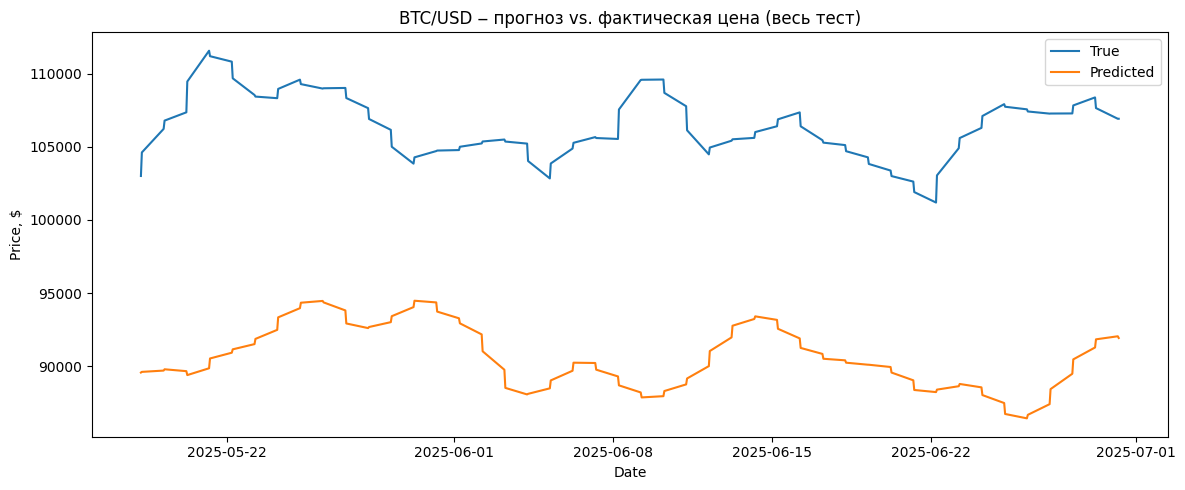

In [422]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# -------- параметры --------
symbol     = 'BTC/USD'
target_col = 'close'

# --- вспомогательная функция ---
def create_sequences(df_sym, feature_cols, time_steps, horizon, target_col):
    X, y, dates = [], [], []
    values = df_sym[feature_cols].values
    for i in range(len(values) - time_steps - horizon + 1):
        X.append(values[i:i + time_steps])
        target_idx = i + time_steps + horizon - 1
        y.append(values[target_idx, feature_cols.index(target_col)])
        dates.append(df_sym.index[target_idx])
    return np.array(X), np.array(y), np.array(dates)

# --- 1) последовательности для BTC ---
df_btc_test = test_scaled.xs(symbol, level='symbol').sort_index()
X_btc, y_btc_scaled, dates_btc = create_sequences(
    df_btc_test, FEATURE_COLS, time_steps, horizon, target_col
)

# --- 2) прогноз ---
y_btc_pred_scaled = model.predict(X_btc, verbose=0).flatten()

# --- 3) inverse transform ---
scaler_btc = feature_scalers[symbol]
close_idx  = FEATURE_COLS.index(target_col)

def inv_transform_close(scaled_vec):
    tmp = np.zeros((scaled_vec.shape[0], len(FEATURE_COLS)))
    tmp[:, close_idx] = scaled_vec
    log_close = scaler_btc.inverse_transform(tmp)[:, close_idx]
    return np.exp(log_close)

true_prices = inv_transform_close(y_btc_scaled)
pred_prices = inv_transform_close(y_btc_pred_scaled)

# --- 4) датафрейм с результатами ---
btc_preds = pd.DataFrame({
    'date': pd.to_datetime(dates_btc),
    'true_price': true_prices,
    'pred_price': pred_prices
}).set_index('date')

# --- 5) метрики ---
rmse = mean_squared_error(btc_preds.true_price, btc_preds.pred_price, squared=False)
mae  = mean_absolute_error(btc_preds.true_price, btc_preds.pred_price)

mean_price = btc_preds.true_price.mean()  # базовый уровень для процента

rmse_pct = rmse / mean_price * 100
mae_pct  = mae  / mean_price * 100

print(f"RMSE  : {rmse:,.2f}  ({rmse_pct:.2f}% of mean price)")
print(f"MAE   : {mae:,.2f}   ({mae_pct:.2f}% of mean price)")
print(btc_preds.head())

# --- 6) график ---
plt.figure(figsize=(12, 5))
plt.plot(btc_preds.index, btc_preds.true_price, label='True')
plt.plot(btc_preds.index, btc_preds.pred_price, label='Predicted')
plt.title('BTC/USD ‒ прогноз vs. фактическая цена (весь тест)')
plt.xlabel('Date')
plt.ylabel('Price, $')
plt.legend()
plt.tight_layout()
plt.show()




RMSE  : 143.61  (5.66% of mean price)
MAE   : 116.86   (4.61% of mean price)
                           true_price   pred_price
date                                              
2025-05-18 05:00:00+00:00  2366.29550  2687.149523
2025-05-18 06:00:00+00:00  2469.39675  2666.727738
2025-05-19 05:00:00+00:00  2572.49800  2644.704442
2025-05-19 06:00:00+00:00  2562.32400  2624.646572
2025-05-20 05:00:00+00:00  2552.15000  2602.153258


c:\Users\haypr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


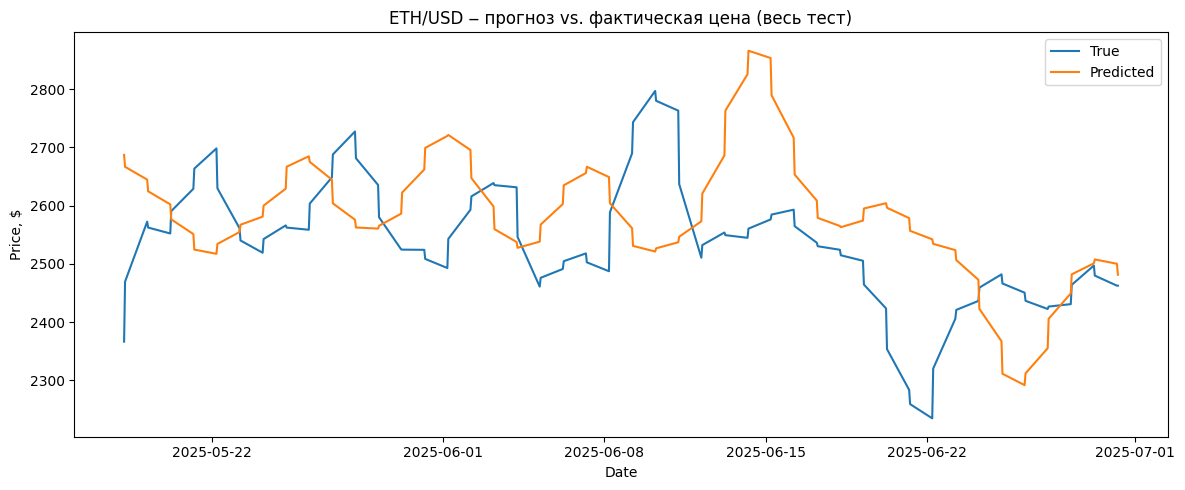

In [423]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# -------- параметры --------
symbol     = 'ETH/USD'
target_col = 'close'

# --- вспомогательная функция ---
def create_sequences(df_sym, feature_cols, time_steps, horizon, target_col):
    X, y, dates = [], [], []
    values = df_sym[feature_cols].values
    for i in range(len(values) - time_steps - horizon + 1):
        X.append(values[i:i + time_steps])
        target_idx = i + time_steps + horizon - 1
        y.append(values[target_idx, feature_cols.index(target_col)])
        dates.append(df_sym.index[target_idx])
    return np.array(X), np.array(y), np.array(dates)

# --- 1) последовательности для BTC ---
df_btc_test = test_scaled.xs(symbol, level='symbol').sort_index()
X_btc, y_btc_scaled, dates_btc = create_sequences(
    df_btc_test, FEATURE_COLS, time_steps, horizon, target_col
)

# --- 2) прогноз ---
y_btc_pred_scaled = model.predict(X_btc, verbose=0).flatten()

# --- 3) inverse transform ---
scaler_btc = feature_scalers[symbol]
close_idx  = FEATURE_COLS.index(target_col)

def inv_transform_close(scaled_vec):
    tmp = np.zeros((scaled_vec.shape[0], len(FEATURE_COLS)))
    tmp[:, close_idx] = scaled_vec
    log_close = scaler_btc.inverse_transform(tmp)[:, close_idx]
    return np.exp(log_close)

true_prices = inv_transform_close(y_btc_scaled)
pred_prices = inv_transform_close(y_btc_pred_scaled)

# --- 4) датафрейм с результатами ---
btc_preds = pd.DataFrame({
    'date': pd.to_datetime(dates_btc),
    'true_price': true_prices,
    'pred_price': pred_prices
}).set_index('date')

# --- 5) метрики ---
rmse = mean_squared_error(btc_preds.true_price, btc_preds.pred_price, squared=False)
mae  = mean_absolute_error(btc_preds.true_price, btc_preds.pred_price)

mean_price = btc_preds.true_price.mean()  # базовый уровень для процента

rmse_pct = rmse / mean_price * 100
mae_pct  = mae  / mean_price * 100

print(f"RMSE  : {rmse:,.2f}  ({rmse_pct:.2f}% of mean price)")
print(f"MAE   : {mae:,.2f}   ({mae_pct:.2f}% of mean price)")
print(btc_preds.head())

# --- 6) график ---
plt.figure(figsize=(12, 5))
plt.plot(btc_preds.index, btc_preds.true_price, label='True')
plt.plot(btc_preds.index, btc_preds.pred_price, label='Predicted')
plt.title('ETH/USD ‒ прогноз vs. фактическая цена (весь тест)')
plt.xlabel('Date')
plt.ylabel('Price, $')
plt.legend()
plt.tight_layout()
plt.show()


RMSE  : 0.57  (25.45% of mean price)
MAE   : 0.56   (25.20% of mean price)
                           true_price  pred_price
date                                             
2025-05-18 05:00:00+00:00    2.334300    1.834414
2025-05-18 06:00:00+00:00    2.361477    1.845923
2025-05-19 05:00:00+00:00    2.388655    1.839238
2025-05-19 06:00:00+00:00    2.380015    1.815531
2025-05-20 05:00:00+00:00    2.371375    1.791889


c:\Users\haypr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


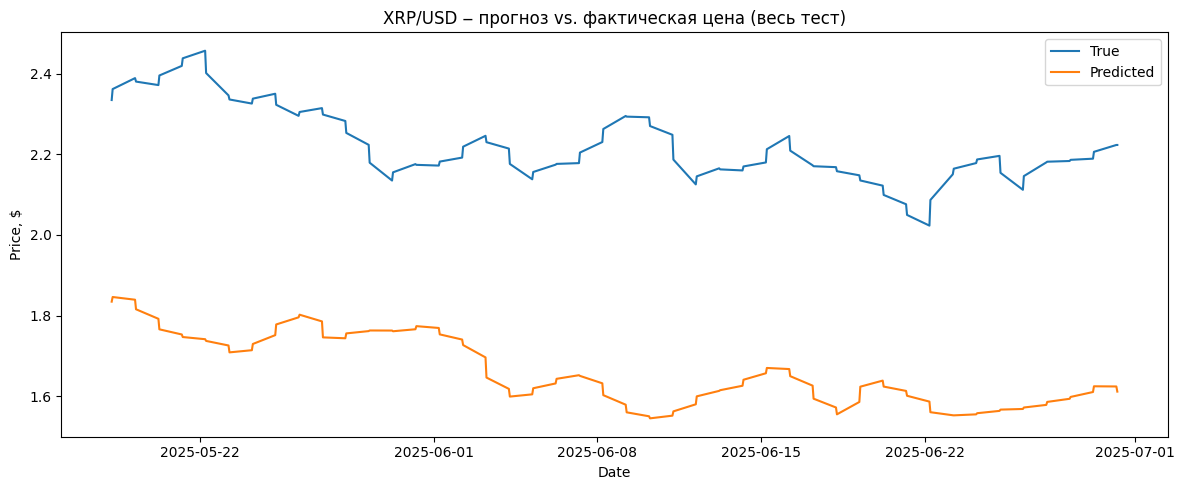

In [424]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# -------- параметры --------
symbol     = 'XRP/USD'
target_col = 'close'

# --- вспомогательная функция ---
def create_sequences(df_sym, feature_cols, time_steps, horizon, target_col):
    X, y, dates = [], [], []
    values = df_sym[feature_cols].values
    for i in range(len(values) - time_steps - horizon + 1):
        X.append(values[i:i + time_steps])
        target_idx = i + time_steps + horizon - 1
        y.append(values[target_idx, feature_cols.index(target_col)])
        dates.append(df_sym.index[target_idx])
    return np.array(X), np.array(y), np.array(dates)

# --- 1) последовательности для BTC ---
df_btc_test = test_scaled.xs(symbol, level='symbol').sort_index()
X_btc, y_btc_scaled, dates_btc = create_sequences(
    df_btc_test, FEATURE_COLS, time_steps, horizon, target_col
)

# --- 2) прогноз ---
y_btc_pred_scaled = model.predict(X_btc, verbose=0).flatten()

# --- 3) inverse transform ---
scaler_btc = feature_scalers[symbol]
close_idx  = FEATURE_COLS.index(target_col)

def inv_transform_close(scaled_vec):
    tmp = np.zeros((scaled_vec.shape[0], len(FEATURE_COLS)))
    tmp[:, close_idx] = scaled_vec
    log_close = scaler_btc.inverse_transform(tmp)[:, close_idx]
    return np.exp(log_close)

true_prices = inv_transform_close(y_btc_scaled)
pred_prices = inv_transform_close(y_btc_pred_scaled)

# --- 4) датафрейм с результатами ---
btc_preds = pd.DataFrame({
    'date': pd.to_datetime(dates_btc),
    'true_price': true_prices,
    'pred_price': pred_prices
}).set_index('date')

# --- 5) метрики ---
rmse = mean_squared_error(btc_preds.true_price, btc_preds.pred_price, squared=False)
mae  = mean_absolute_error(btc_preds.true_price, btc_preds.pred_price)

mean_price = btc_preds.true_price.mean()  # базовый уровень для процента

rmse_pct = rmse / mean_price * 100
mae_pct  = mae  / mean_price * 100

print(f"RMSE  : {rmse:,.2f}  ({rmse_pct:.2f}% of mean price)")
print(f"MAE   : {mae:,.2f}   ({mae_pct:.2f}% of mean price)")
print(btc_preds.head())

# --- 6) график ---
plt.figure(figsize=(12, 5))
plt.plot(btc_preds.index, btc_preds.true_price, label='True')
plt.plot(btc_preds.index, btc_preds.pred_price, label='Predicted')
plt.title('XRP/USD ‒ прогноз vs. фактическая цена (весь тест)')
plt.xlabel('Date')
plt.ylabel('Price, $')
plt.legend()
plt.tight_layout()
plt.show()
